In [1]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [1]:
import yaml
import pprint
import matplotlib.pyplot as plt
from pprint import pprint
import tikzplotlib as tikz
from results.utils import Experience, set_hashseed, loader, plot_metrics
from array2gif import write_gif
set_hashseed(0)

import experiences.experience


In [2]:
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
with open('results/tested_config.yml') as f:
    tested_cfg = yaml.load(f, Loader=loader)
Experience.save_folder = 'results/simuls/'
Experience.objects.flush()
for cfg in tested_cfg:
    Experience.objects.add(Experience(**cfg))

## Regularisation 
### Forward-Backward

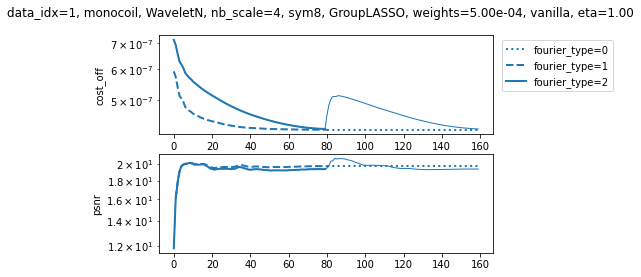

In [5]:
offline = Experience.objects.filter(mode='and',
                               problem__fourier_type__in=[0, 1],
                               problem__regularisation__class='GroupLASSO',
                               problem__regularisation__weights=5e-4,
                               solver__reg_factor=1.,
                               solver__algo__in=['vanilla','condatvu']
                               )
online2vanilla = Experience.objects.filter(mode='and',
                               problem__fourier_type=2,
                               problem__regularisation__class='GroupLASSO',
                               problem__regularisation__weights=5e-4,
                               solver__algo='vanilla'
                               )
online2vanilla = offline.union(online2vanilla)
fig = plot_metrics(online2vanilla,('cost_off','psnr'),('nb_run','reg_factor'))



### Use a basic preconditionner

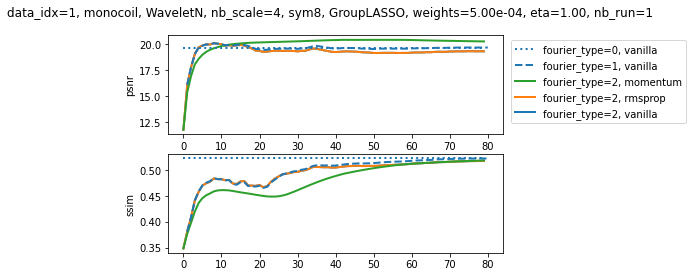

In [6]:
ds2 = Experience.objects.filter(mode='and',
                                problem__fourier_type =2,
                                problem__regularisation__class='GroupLASSO',
                                problem__regularisation__weights=5e-4,
                                solver__nb_run=1)
ds2 = ds2.filter(mode='loose_and',
                                solver__algo__in=['vanilla','rmsprop','momentum'],
                                solver__gamma=1.00,
                                solver__eta=1.00,
                                solver__beta=1.00
                                )
ds2 = ds2.union(offline)
fig = plot_metrics(ds2,('psnr','ssim'),('nb_run','reg_factor','beta','gamma'),default_offset=0,log=False)

## No regularisation

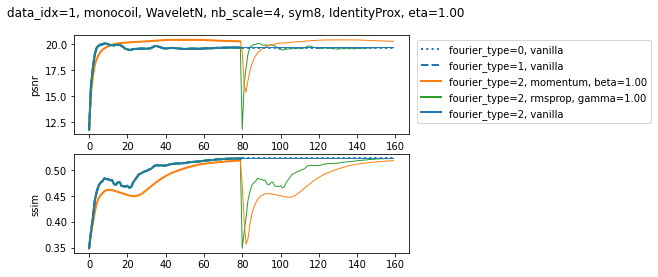

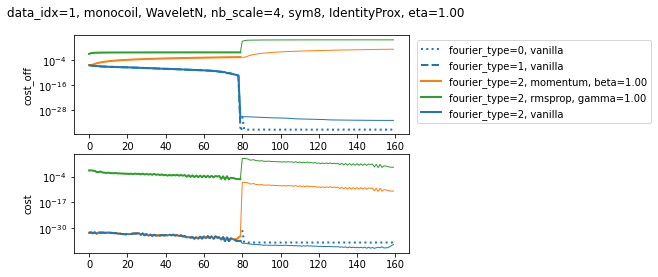

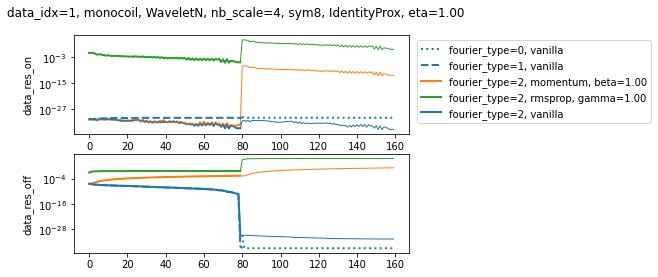

In [18]:

offline_no_reg = Experience.objects.filter(mode='loose_and',
                               problem__fourier_type__in=[0, 1, 2],
                               problem__regularisation__class='IdentityProx',
                               solver__algo='vanilla',
                               solver__reg_factor=1.,
                               )
ds2 = Experience.objects.filter(mode='loose_and',
                                problem__fourier_type=2,
                                problem__regularisation__class='IdentityProx',
                                solver__algo__in=['rmsprop', 'vanilla','momentum'],
                                solver__eta=1.0,
                                solver__gamma=1.00,
                                solver__beta=1.00
                                )
ds2 = ds2.union(offline_no_reg)
fig = plot_metrics(ds2, ('psnr', 'ssim'), ('nb_run', 'reg_factor'),log=False)
fig2 = plot_metrics(ds2, ('cost_off','cost'), ('nb_run', 'reg_factor'),log=True)
fig2 = plot_metrics(ds2, ('data_res_on','data_res_off'), ('nb_run', 'reg_factor'),log=True)